# Capstone Project - Clustering neighborhoods in Belo Horizonte - Brasil


### Introduction

In this problem I am trying to discover the best neighborhood to open a Vegan / Vegetarian restaurant in Belo Horizonte.

We will try to find neighborhoods that has lots of restaurantes, bars and other comercial place, but no Vegan/Vegetarian restaurants nearby.



### Data

First of all, in the Wikipedia site, https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Belo_Horizonte I will get the neighborhood´s list parsing with Beautiful Soup.
    
After that, I will access http://geocoder.pbh.gov.br/geocoder/0.0.1/address?bairro={}, that is a City Hall official site and get the UTM directions of all neighborhoods.

Them, I will use the pyproj library to get the Geographical Coordinates and use the foursquase API.

With this DataFrame, I can access the foursquare data to cluster and define the best place to open this Vegas/Vegetarian Restaurant.

## Part 1

#### Importing the libraries

In [1]:
import requests
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import re
import pyproj
from geopy.geocoders import Nominatim
import folium
from pyproj import Proj, transform, CRS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print("Libraries imported.")

Libraries imported.


#### Requesting information in wikipedia URL

In [2]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Belo_Horizonte'
page = urllib.request.urlopen(url)  

#### Parsing into the BeautifulSoup format

In [3]:
soup = BeautifulSoup(page, "lxml")

#### Creating and formatting the Neighborhood (Bairro) DataFrame

In [4]:
table_contents=[]
table = soup.body.findAll('table')[3]

table2 = table.findAll('tr')

for row in table2:
    cell = {}
    cell["Número"] = row.findAll('td')[0:1]
    cell["Zonas"] = row.findAll('td')[1:2]
    cell["Regionais"] = row.findAll('td')[2:3]
    cell["Bairros"] = row.findAll('td')[3:4]
    table_contents.append(cell)

   
tabela_final = []
for i in table_contents:
    
    celula = {}
    teste1 = str(i['Número'])
    teste2 = str(i['Zonas'])
    teste3 = str(i['Regionais'])
    teste4 = str(i['Bairros'])
   
    Resultado1 = re.search('(?<=\>).+?(?=\<)', teste1)
    if Resultado1:
        celula['Índice'] = Resultado1.group()
    Resultado2 = re.search('(?<=\>).+?(?=\<)', teste2)
    if Resultado2:
        celula['Zona'] = Resultado2.group()
    Resultado3 = re.search('(?<=\>).+?(?=\<)', teste3)
    if Resultado3:
        celula['Regional'] = Resultado3.group()
    Resultado4 = re.search('(?<=\>).+?(?=\<)', teste4)
    if Resultado4:
        celula['Bairro'] = Resultado4.group()
    if Resultado1:
        if Resultado2:
            if Resultado3:
                if Resultado4:
                    tabela_final.append(celula)
                    
#print(tabela_final)
df = pd.DataFrame(tabela_final)
df.Bairro = df.Bairro.str.replace(' ', '%20')
df.Bairro = df.Bairro.str.replace('á', 'a')
df.Bairro = df.Bairro.str.replace('é', 'e')
df.Bairro = df.Bairro.str.replace('í', 'i')
df.Bairro = df.Bairro.str.replace('ó', 'o')
df.Bairro = df.Bairro.str.replace('ú', 'u')
df.Bairro = df.Bairro.str.replace('ã', 'a')
df.Bairro = df.Bairro.str.replace('õ', 'o')
df.Bairro = df.Bairro.str.replace('â', 'a')
df.Bairro = df.Bairro.str.replace('ê', 'e')
df.Bairro = df.Bairro.str.replace('ô', 'o')
df.Bairro = df.Bairro.str.replace('ç', 'c')
df.Bairro = df.Bairro.str.replace('Á', 'A')
df.Bairro = df.Bairro.str.replace("\\(.*\\)", "")


#### Visualizing the Dataframe

In [5]:
df.head()

Índice        Zona           Regional             Bairro
0      1  ZONA LESTE              Leste  Sagrada%20Familia
1      2    ZONA SUL              Oeste            Buritis
2      3  ZONA OESTE           Noroeste  Padre%20Eustaquio
3      4  ZONA OESTE           Barreiro            Lindeia
4      5  ZONA NORTE  Pamp./ Venda Nova     Santa%20Monica

#### Dataframe Shape

In [6]:
df.shape

(503, 4)

#### Acessing the BH´s City Hall website to extract coordinates

In [7]:
new_df = df.set_index('Bairro')
new_df.insert(3,'Longitude', 0)
new_df.insert(4,'Latitude', 0)

for i in df.Bairro:
    #print(i)
    url2 = 'http://geocoder.pbh.gov.br/geocoder/0.0.1/address?bairro={}'.format(i)
    try:
        page = urllib.request.urlopen(url2)
        soup = BeautifulSoup(page, "lxml")
        #print(soup)
        table2 = str(soup.body.findAll('p'))
        #print(table2)
        Resultado1 = str(re.findall('\(.*?\)', table2))
        longitude = Resultado1.split()[0]
        new_df.loc[[i],['Longitude']] = str(longitude[3:])
        #print(longitude[:-3])
        latitude = Resultado1.split()[1]
        new_df.loc[[i],['Latitude']] = str(latitude[:-3])
        #print(latitude[3:])
    except:
        pass


In [8]:
new_df.head()

Índice        Zona           Regional         Longitude  \
Bairro                                                                      
Sagrada%20Familia      1  ZONA LESTE              Leste   612477.03312361   
Buritis                2    ZONA SUL              Oeste  607309.483827017   
Padre%20Eustaquio      3  ZONA OESTE           Noroeste   606271.46842147   
Lindeia                4  ZONA OESTE           Barreiro  598880.339164215   
Santa%20Monica         5  ZONA NORTE  Pamp./ Venda Nova  606776.058212129   

                           Latitude  
Bairro                               
Sagrada%20Familia   7798062.0556387  
Buritis             7790358.9561129  
Padre%20Eustaquio  7796962.48553224  
Lindeia            7789696.98561535  
Santa%20Monica     7806845.18917881

In [9]:
new_df.shape

(503, 5)

#### Formatting and reindexing

In [10]:
final_df = new_df.reset_index()
final_df.Bairro = final_df.Bairro.str.replace('%20', ' ')
final_df = final_df.drop('Índice', axis='columns')

final_df.head()

Bairro        Zona           Regional         Longitude  \
0  Sagrada Familia  ZONA LESTE              Leste   612477.03312361   
1          Buritis    ZONA SUL              Oeste  607309.483827017   
2  Padre Eustaquio  ZONA OESTE           Noroeste   606271.46842147   
3          Lindeia  ZONA OESTE           Barreiro  598880.339164215   
4     Santa Monica  ZONA NORTE  Pamp./ Venda Nova  606776.058212129   

           Latitude  
0   7798062.0556387  
1   7790358.9561129  
2  7796962.48553224  
3  7789696.98561535  
4  7806845.18917881

In [11]:
final_df.shape

(503, 5)

In [12]:
final_df

Bairro        Zona           Regional         Longitude  \
0      Sagrada Familia  ZONA LESTE              Leste   612477.03312361   
1              Buritis    ZONA SUL              Oeste  607309.483827017   
2      Padre Eustaquio  ZONA OESTE           Noroeste   606271.46842147   
3              Lindeia  ZONA OESTE           Barreiro  598880.339164215   
4         Santa Monica  ZONA NORTE  Pamp./ Venda Nova  606776.058212129   
..                 ...         ...                ...               ...   
498          Guanabara  ZONA LESTE           Nordeste  615394.720332093   
499  Lagoa da Pampulha  ZONA NORTE           Pampulha                     
500             Sumare  ZONA NORTE           Noroeste  608249.777374251   
501   Vila Vera Cruz I  ZONA LESTE              Leste  615357.811798638   
502  Vila Vera Cruz II  ZONA LESTE              Leste  615427.035914124   

             Latitude  
0     7798062.0556387  
1     7790358.9561129  
2    7796962.48553224  
3    7789696.98561535  
4    7806845.18917881  
..                ...  
498  7803532.50165304  
499                 0  
500  7800860.27604791  
501  7798452.88747958  
502  7798002.26759501  

[503 rows x 5 columns]

#### Using pyproj to transform the coordinates

In [13]:
tab_cord = []

for i in final_df.index:
    
    x1 = final_df['Longitude'][i]
    y1 = final_df['Latitude'][i]
    cel_cord = {}
    try:
        fx1 = float(x1)
        fy1 = float(y1)
        
        x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
        print(type(x2), x2, type(y2), y2)
        
        cel_cord['Bairro'] = final_df['Bairro'][i]
        cel_cord['Zona'] = final_df['Zona'][i]
        cel_cord['Regional'] = final_df['Regional'][i]
        cel_cord['Long'] = x2
        cel_cord['Lat'] = y2
        tab_cord.append(cel_cord)
    except ValueError:
        final_df = final_df.drop(i, axis=0)
    
    


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.925402192714756 <class 'float'> -19.910512870809868
<class 'float'> -43.974317130987465 <class 'float'> -19.980404002285965
<class 'float'> -43.984619151106756 <class 'float'> -19.920796153793212
<class 'float'> -44.05484015489758 <class 'float'> -19.9868328390216


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.9803698724782 <class 'float'> -19.8314746228165
<class 'float'> -43.994882572075205 <class 'float'> -19.830033284707675
<class 'float'> -43.945068479580875 <class 'float'> -19.88604800771623
<class 'float'> -43.945068479580875 <class 'float'> -19.88604800771623
<class 'float'> -43.946123219580656 <class 'float'> -19.950240368284412
<class 'float'> -43.892253367173886 <class 'float'> -19.903251855932645
<class 'float'> -43.972320820150934 <class 'float'> -19.80253926432278


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.990482058017285 <class 'float'> -19.819738355727573
<class 'float'> -43.9852835599769 <class 'float'> -19.802418228489284
<class 'float'> -43.91465975604187 <class 'float'> -19.943002308285923
<class 'float'> -43.92968011260077 <class 'float'> -19.959606722927056
<class 'float'> -43.93827294140903 <class 'float'> -19.929718801507484
<class 'float'> -43.978589585654554 <class 'float'> -19.832447966762714


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.99547531328691 <class 'float'> -19.952673228728525
<class 'float'> -43.92699065380995 <class 'float'> -19.927723964802578
<class 'float'> -43.92699065380995 <class 'float'> -19.927723964802578
<class 'float'> -44.02421116330847 <class 'float'> -19.912431151921176
<class 'float'> -43.90662717948009 <class 'float'> -19.897001365850816
<class 'float'> -43.960877242738 <class 'float'> -19.948425927208657


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.98549167431176 <class 'float'> -19.889128612622205
<class 'float'> -43.993217883175994 <class 'float'> -19.893015050298043
<class 'float'> -43.95556996516497 <class 'float'> -19.83400260944604
<class 'float'> -43.96361003236446 <class 'float'> -19.828115206600962


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.936380763025724 <class 'float'> -19.92546306898386
<class 'float'> -43.903286227738796 <class 'float'> -19.867629714748
<class 'float'> -43.942459794551795 <class 'float'> -19.8101722753889
<class 'float'> -43.90123821341423 <class 'float'> -19.84077973775299
<class 'float'> -44.01127133828572 <class 'float'> -19.87633429734618
<class 'float'> -43.92395774808414 <class 'float'> -19.91906902323974


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.930564962386775 <class 'float'> -19.831681133791463
<class 'float'> -43.925567920601 <class 'float'> -19.893079090601148
<class 'float'> -43.95810559030828 <class 'float'> -19.91838700807399
<class 'float'> -43.95810559030828 <class 'float'> -19.91838700807399
<class 'float'> -43.975712818418565 <class 'float'> -19.961629631202054


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.982263415111106 <class 'float'> -19.930073823858372
<class 'float'> -43.88009750077208 <class 'float'> -19.92017263167133
<class 'float'> -43.919059425865505 <class 'float'> -19.887210921719518
<class 'float'> -43.97876480401896 <class 'float'> -19.943809306074037
<class 'float'> -44.00476942299788 <class 'float'> -19.994925487146737
<class 'float'> -44.00175578704866 <class 'float'> -19.91100703462201
<class 'float'> -43.953697891954874 <class 'float'> -19.803819779523394


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.897895781617294 <class 'float'> -19.90328283318078
<class 'float'> -43.97110404489028 <class 'float'> -19.929538542663334
<class 'float'> -43.921606716049986 <class 'float'> -19.861165843949237
<class 'float'> -43.917465693952984 <class 'float'> -19.842398494009426
<class 'float'> -43.90876078361433 <class 'float'> -19.91633792725514
<class 'float'> -43.993844056889195 <class 'float'> -19.83277213435511


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.971257390800666 <class 'float'> -19.91082318457549
<class 'float'> -44.00976793535583 <class 'float'> -19.94745297261688
<class 'float'> -43.982083997367404 <class 'float'> -19.82411087944013
<class 'float'> -43.92855159280149 <class 'float'> -19.95227321688989
<class 'float'> -43.93479637627379 <class 'float'> -19.888748837512047
<class 'float'> -44.00763613769613 <class 'float'> -19.98762859827479
<class 'float'> -43.99617259880834 <class 'float'> -19.958400842910653


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.025052933679454 <class 'float'> -19.9960195079829
<class 'float'> -43.93166257573559 <class 'float'> -19.920655289526675
<class 'float'> -43.93166257573559 <class 'float'> -19.920655289526675
<class 'float'> -43.937733742239374 <class 'float'> -19.939419270431255


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.93524549170457 <class 'float'> -19.833229699163923
<class 'float'> -43.99780320951252 <class 'float'> -19.956948107639796
<class 'float'> -43.972944666400686 <class 'float'> -19.947149695913698
<class 'float'> -43.972944666400686 <class 'float'> -19.947149695913698
<class 'float'> -43.972806756093526 <class 'float'> -19.910750144825883


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.94052848505376 <class 'float'> -19.903217688926592
<class 'float'> -43.92650060329229 <class 'float'> -19.839568277987226
<class 'float'> -43.958685995357655 <class 'float'> -19.806867426779466
<class 'float'> -44.011086036807384 <class 'float'> -20.007683319411576
<class 'float'> -43.936222639454826 <class 'float'> -19.911908500922888
<class 'float'> -43.936222639454826 <class 'float'> -19.911908500922888


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.02348544185294 <class 'float'> -19.983278166687292
<class 'float'> -43.968842353665586 <class 'float'> -19.806782521971726
<class 'float'> -44.00779173122211 <class 'float'> -19.892056900904503
<class 'float'> -43.9897668141392 <class 'float'> -19.900905692861873


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.9897668141392 <class 'float'> -19.900905692861873
<class 'float'> -43.94994183296368 <class 'float'> -19.93384637575777
<class 'float'> -43.95719809114033 <class 'float'> -19.897534653239457
<class 'float'> -43.93391685869009 <class 'float'> -19.84113492653915
<class 'float'> -44.001077624469595 <class 'float'> -19.91094935639354
<class 'float'> -43.99643233985885 <class 'float'> -19.933932940134365


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.90776287017283 <class 'float'> -19.940549575749966
<class 'float'> -43.88170392825791 <class 'float'> -19.857512338927815
<class 'float'> -44.00217111273807 <class 'float'> -19.903678884199785
<class 'float'> -44.00079086103885 <class 'float'> -19.938423646859135
<class 'float'> -43.96031803170712 <class 'float'> -19.842713504691627


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.992268365513596 <class 'float'> -19.824646309000595
<class 'float'> -43.94875338437132 <class 'float'> -19.88798768327156
<class 'float'> -43.99880983311347 <class 'float'> -19.967216247294072
<class 'float'> -43.91142555243901 <class 'float'> -19.894431146872243
<class 'float'> -43.996265888879286 <class 'float'> -19.814027333914694
<class 'float'> -43.93801489366257 <class 'float'> -19.851494377546533


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.93774683871236 <class 'float'> -19.888771345633007
<class 'float'> -43.942302651656995 <class 'float'> -19.862822185230137
<class 'float'> -43.92581594591609 <class 'float'> -19.937932835141254
<class 'float'> -43.94532346711593 <class 'float'> -19.98112765042591
<class 'float'> -43.904525536377214 <class 'float'> -19.863165902263038
<class 'float'> -43.90537925637142 <class 'float'> -19.886163804379038


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.031373011111945 <class 'float'> -20.02303988676956
<class 'float'> -43.913603682823926 <class 'float'> -19.843816028583845
<class 'float'> -43.99945778284232 <class 'float'> -19.89866075306232
<class 'float'> -44.02185534672118 <class 'float'> -20.006269689826404


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.90639979636152 <class 'float'> -19.908945691596756
<class 'float'> -43.8992741748763 <class 'float'> -19.85607052023213
<class 'float'> -43.92211009003647 <class 'float'> -19.948131122440337
<class 'float'> -44.03970125758615 <class 'float'> -20.0108028775533


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.94386748141378 <class 'float'> -19.95653946418951
<class 'float'> -43.92693518183433 <class 'float'> -19.861470645137878
<class 'float'> -44.001636736854934 <class 'float'> -19.997505119024964
<class 'float'> -44.01525302170786 <class 'float'> -19.908097101252938
<class 'float'> -43.916322873339006 <class 'float'> -19.846116763947762
<class 'float'> -43.97046428120684 <class 'float'> -19.805375805814847
<class 'float'> -43.9998895103452 <class 'float'> -19.802356662930176


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -44.02363757115597 <class 'float'> -19.903974610862104
<class 'float'> -43.99303447974073 <class 'float'> -19.92815956262453
<class 'float'> -43.98120519106292 <class 'float'> -19.980145370081406
<class 'float'> -43.98120519106292 <class 'float'> -19.980145370081406
<class 'float'> -44.051294498721916 <class 'float'> -19.996520929173116


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.96805139317357 <class 'float'> -19.808972208165784
<class 'float'> -43.98182003947588 <class 'float'> -19.92831167068001
<class 'float'> -43.954856026547276 <class 'float'> -19.84553659034828
<class 'float'> -43.971378636025484 <class 'float'> -19.902002363305552
<class 'float'> -43.958510992251284 <class 'float'> -19.907736075167552


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.94657129182098 <class 'float'> -19.954340917122913
<class 'float'> -43.94838768842149 <class 'float'> -19.829607362126602
<class 'float'> -44.015655901629174 <class 'float'> -19.93834131200156
<class 'float'> -43.973812184172445 <class 'float'> -19.94841993449882
<class 'float'> -44.018287245831985 <class 'float'> -20.000555010468382
<class 'float'> -43.99574235857233 <class 'float'> -19.907982315083256
<class 'float'> -43.90718977804102 <class 'float'> -19.875119627285173


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.94890503771774 <class 'float'> -19.86881373579603
<class 'float'> -43.93845737478947 <class 'float'> -19.846411596470322
<class 'float'> -43.99226267062414 <class 'float'> -19.828446960215423
<class 'float'> -43.908850615369936 <class 'float'> -19.943497263891217
<class 'float'> -43.933687235588486 <class 'float'> -19.85693138864514
<class 'float'> -43.98820306333389 <class 'float'> -19.987452993143865


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.98820306333389 <class 'float'> -19.987452993143865
<class 'float'> -43.99686715974072 <class 'float'> -19.869107767048757
<class 'float'> -43.95327143421769 <class 'float'> -19.951198764535985
<class 'float'> -43.88888018130043 <class 'float'> -19.903113473860063


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.93972186229311 <class 'float'> -19.95412506913289
<class 'float'> -43.96647642174815 <class 'float'> -19.938131665153605
<class 'float'> -43.9140763752379 <class 'float'> -19.937785039541517
<class 'float'> -43.895795502475366 <class 'float'> -19.842294512555128


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.95623475603737 <class 'float'> -19.928242300897082
<class 'float'> -44.01614557335776 <class 'float'> -19.99401806756343
<class 'float'> -44.01262517105296 <class 'float'> -19.997694239902405
<class 'float'> -43.94191778355669 <class 'float'> -19.955600726193623
<class 'float'> -44.01182682143179 <class 'float'> -19.931275141078796
<class 'float'> -43.96568032576047 <class 'float'> -19.9442700187933
<class 'float'> -43.96568032576047 <class 'float'> -19.9442700187933


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.99511973799959 <class 'float'> -19.80893303242424
<class 'float'> -43.914366111804746 <class 'float'> -19.906336952552707
<class 'float'> -43.98190746240012 <class 'float'> -19.910681417696882
<class 'float'> -43.943546678782724 <class 'float'> -19.821039325718722
<class 'float'> -44.01781056952027 <class 'float'> -19.893318749422704
<class 'float'> -43.94971076266291 <class 'float'> -19.949145232582275


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.92758482505605 <class 'float'> -19.89669690053056
<class 'float'> -44.033793213793224 <class 'float'> -19.99365252225021
<class 'float'> -43.90411911219472 <class 'float'> -19.91608064801198
<class 'float'> -43.99180712090495 <class 'float'> -19.99807352632281
<class 'float'> -43.987934202173726 <class 'float'> -19.952707461638397


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.02785383514371 <class 'float'> -19.996810091104813
<class 'float'> -43.93123819771087 <class 'float'> -19.875830067133233
<class 'float'> -43.93123819771087 <class 'float'> -19.875830067133233
<class 'float'> -43.98350450630993 <class 'float'> -19.966001176111593
<class 'float'> -44.00406169707069 <class 'float'> -19.85433412822439
<class 'float'> -44.0119123894174 <class 'float'> -19.989119671145914


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.96760820229779 <class 'float'> -19.83625535614494
<class 'float'> -43.88655789545464 <class 'float'> -19.853059115469758
<class 'float'> -43.970080161222484 <class 'float'> -19.93547280183585
<class 'float'> -43.99810774021198 <class 'float'> -19.957026614444306
<class 'float'> -43.89115671057872 <class 'float'> -19.851362608131446
<class 'float'> -43.96247828215253 <class 'float'> -19.89345264290236


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.8986345476367 <class 'float'> -19.918954160123583
<class 'float'> -43.911795559516975 <class 'float'> -19.839519109706156
<class 'float'> -43.93243434348022 <class 'float'> -19.902027707190975
<class 'float'> -43.95935673667496 <class 'float'> -19.85555311426321
<class 'float'> -43.986341259545064 <class 'float'> -19.968511009625864


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.95613328071993 <class 'float'> -19.88806227511902
<class 'float'> -43.90722483791117 <class 'float'> -19.8742674189663
<class 'float'> -44.01745368996933 <class 'float'> -19.872368464548398
<class 'float'> -43.99316352536123 <class 'float'> -19.977332545683737


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.93661241096506 <class 'float'> -19.93065181613125
<class 'float'> -43.96347896975966 <class 'float'> -19.966787987634945
<class 'float'> -43.93408337374899 <class 'float'> -19.895216371021654
<class 'float'> -43.97614645392297 <class 'float'> -19.912002432359117
<class 'float'> -43.954919757400255 <class 'float'> -19.86307607237367
<class 'float'> -44.00485296106479 <class 'float'> -19.954770403523487


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.951098887549165 <class 'float'> -19.90330164119549
<class 'float'> -43.95182270148825 <class 'float'> -19.91330036758567
<class 'float'> -43.95182270148825 <class 'float'> -19.91330036758567
<class 'float'> -43.960814081404216 <class 'float'> -19.8990953159295
<class 'float'> -43.95934573789746 <class 'float'> -19.80517786260931


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.94941995763413 <class 'float'> -19.873733618996376
<class 'float'> -44.00761488483876 <class 'float'> -20.01056394679771
<class 'float'> -43.917459800536484 <class 'float'> -19.932198108588317
<class 'float'> -44.005024408506536 <class 'float'> -19.841497411610554
<class 'float'> -44.019824315617036 <class 'float'> -19.867495761318338
<class 'float'> -43.99448031235639 <class 'float'> -19.927798533727945


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.024672947294114 <class 'float'> -20.023110061436626
<class 'float'> -43.909740468833064 <class 'float'> -19.85748791587482
<class 'float'> -43.91497758121841 <class 'float'> -19.87438202271065
<class 'float'> -43.906105479355624 <class 'float'> -19.850025355236305
<class 'float'> -43.88605628536609 <class 'float'> -19.83422104264479
<class 'float'> -43.91153441890866 <class 'float'> -19.93639121417035
<class 'float'> -43.95271165172312 <class 'float'> -19.85841442977035


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.93190761100095 <class 'float'> -19.86181642629854
<class 'float'> -43.92088810275898 <class 'float'> -19.86659495115897
<class 'float'> -43.91532290471388 <class 'float'> -19.93053001346361
<class 'float'> -43.94113665493755 <class 'float'> -19.90919869322654
<class 'float'> -43.94113665493755 <class 'float'> -19.90919869322654


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.89462713897947 <class 'float'> -19.91465022369829
<class 'float'> -43.9454530125585 <class 'float'> -19.870718624135993
<class 'float'> -43.9454530125585 <class 'float'> -19.870718624135993
<class 'float'> -43.9331585722492 <class 'float'> -19.945242819744422
<class 'float'> -44.006172006676586 <class 'float'> -19.939085661872728
<class 'float'> -43.92748404082186 <class 'float'> -19.86799445905556


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.041341468636695 <class 'float'> -20.003629993565347
<class 'float'> -43.90484382748084 <class 'float'> -19.93369609592465
<class 'float'> -43.954656917305385 <class 'float'> -19.955451442525316
<class 'float'> -43.91008112178903 <class 'float'> -19.933831643843106
<class 'float'> -43.964896608286516 <class 'float'> -19.95329626679342


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.956702841228825 <class 'float'> -19.897665415066925
<class 'float'> -43.88393856076686 <class 'float'> -19.90319961939575
<class 'float'> -43.951204657650116 <class 'float'> -19.95246421349383
<class 'float'> -43.891897221087675 <class 'float'> -19.89775662117149


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.98833085045336 <class 'float'> -19.920883441607625
<class 'float'> -43.89250845970085 <class 'float'> -19.820812666650095
<class 'float'> -44.039381140559016 <class 'float'> -20.012725812083172
<class 'float'> -43.996995105845 <class 'float'> -19.910943031490724
<class 'float'> -43.957641778166305 <class 'float'> -19.89032766039961
<class 'float'> -44.052192434120144 <class 'float'> -19.99651498320659


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.88879739777656 <class 'float'> -19.862774689519032
<class 'float'> -43.91960496171825 <class 'float'> -19.911044707204077
<class 'float'> -43.884203781496 <class 'float'> -19.920630800400087
<class 'float'> -44.00828730078759 <class 'float'> -19.925304155819283


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.95492174158215 <class 'float'> -19.86872455221695
<class 'float'> -43.965108047482055 <class 'float'> -19.933920087775075
<class 'float'> -43.91681008045708 <class 'float'> -19.880220129188263
<class 'float'> -43.918788537194914 <class 'float'> -19.86860027762722
<class 'float'> -43.88337192689083 <class 'float'> -19.832065259106503
<class 'float'> -44.002427731923135 <class 'float'> -19.932695332571452


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.98344942092237 <class 'float'> -19.96700993801398
<class 'float'> -44.0087642465739 <class 'float'> -19.92043917435006
<class 'float'> -43.91239746888209 <class 'float'> -19.840866736297638
<class 'float'> -44.02389541345289 <class 'float'> -20.01649679142788
<class 'float'> -44.00800682488011 <class 'float'> -19.9109700992349


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.919255680582395 <class 'float'> -19.933495711093634
<class 'float'> -43.964840385397125 <class 'float'> -19.89036236531342
<class 'float'> -43.92813137316417 <class 'float'> -19.846800470992918
<class 'float'> -43.97784481470762 <class 'float'> -20.00464357306026
<class 'float'> -44.03280753560626 <class 'float'> -20.00028543078919


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.9801508822391 <class 'float'> -19.95987905010897
<class 'float'> -44.00116485771649 <class 'float'> -20.002589766987196
<class 'float'> -43.96430619506688 <class 'float'> -19.949709028416777
<class 'float'> -43.94766120843254 <class 'float'> -19.907659933019875
<class 'float'> -43.985828428042026 <class 'float'> -19.832295747707104
<class 'float'> -44.02787193436611 <class 'float'> -20.0101129329942


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.96647723092282 <class 'float'> -19.95120439499611
<class 'float'> -43.86749074130574 <class 'float'> -19.832075204219713
<class 'float'> -43.94846469577377 <class 'float'> -19.83243035941651
<class 'float'> -43.987148830682216 <class 'float'> -19.894980723019604
<class 'float'> -43.95972147743066 <class 'float'> -19.94384531891926


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.00832341240292 <class 'float'> -19.88918444791546
<class 'float'> -43.966119299074535 <class 'float'> -19.810310035404722
<class 'float'> -44.00932564165824 <class 'float'> -20.009288190236173
<class 'float'> -43.92383495040954 <class 'float'> -19.799649974519365
<class 'float'> -43.947769283119314 <class 'float'> -19.798736093732177


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.927573883433155 <class 'float'> -19.850237794608326
<class 'float'> -43.89326000043297 <class 'float'> -19.91908845058717
<class 'float'> -43.89597472856805 <class 'float'> -19.84704131654547
<class 'float'> -43.962640574191724 <class 'float'> -19.822402943162515
<class 'float'> -43.92964533859337 <class 'float'> -19.86130572395405


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -44.01906954930239 <class 'float'> -20.005259207271965
<class 'float'> -43.9374813981506 <class 'float'> -19.812489818439982
<class 'float'> -43.95134597480155 <class 'float'> -19.81804848445919
<class 'float'> -44.0276520666472 <class 'float'> -19.97521852432712
<class 'float'> -43.964404232997005 <class 'float'> -19.809658456755475
<class 'float'> -43.95409973238126 <class 'float'> -19.884614411970084


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.90214871858939 <class 'float'> -19.850975959486224
<class 'float'> -43.913654763329326 <class 'float'> -19.877058158545772
<class 'float'> -43.96483417198882 <class 'float'> -19.95411047960637
<class 'float'> -44.03263479061618 <class 'float'> -20.011140775788277
<class 'float'> -43.938543055107424 <class 'float'> -19.81502145907412


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.99021440704199 <class 'float'> -19.99365370343545
<class 'float'> -44.033386866121006 <class 'float'> -20.008210858096056
<class 'float'> -43.99163315962632 <class 'float'> -19.817966521627902
<class 'float'> -43.94367518339286 <class 'float'> -19.848149641717058
<class 'float'> -43.9363833548524 <class 'float'> -19.817817605023777
<class 'float'> -43.9363833548524 <class 'float'> -19.817817605023777


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -44.00949278207132 <class 'float'> -19.85186551283468
<class 'float'> -44.020551610365736 <class 'float'> -20.014256362690407
<class 'float'> -43.99171680944236 <class 'float'> -19.97337410354057
<class 'float'> -43.93810992141514 <class 'float'> -19.811331934341606
<class 'float'> -43.944128819393704 <class 'float'> -19.869348483147913


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.9355942119451 <class 'float'> -19.866747923905844
<class 'float'> -43.91379482289139 <class 'float'> -19.943092236004233
<class 'float'> -44.0047483500573 <class 'float'> -19.95150039307556
<class 'float'> -44.03335515258938 <class 'float'> -20.01665392773847
<class 'float'> -43.972994973570145 <class 'float'> -19.938102256070614


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.92111745173861 <class 'float'> -19.86691731006153
<class 'float'> -44.04646919741587 <class 'float'> -19.98799385818154
<class 'float'> -43.99103561020187 <class 'float'> -19.94402497169028
<class 'float'> -44.027960593811805 <class 'float'> -19.98332886263199
<class 'float'> -44.014427298084364 <class 'float'> -19.86904043298389


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.03143804972879 <class 'float'> -19.982404028809626
<class 'float'> -43.928959328375385 <class 'float'> -19.958045325711844
<class 'float'> -44.00906583304834 <class 'float'> -19.920284646880635
<class 'float'> -44.0056377422575 <class 'float'> -19.945591860362505
<class 'float'> -43.96483913114218 <class 'float'> -19.94696911444797


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.019641659338454 <class 'float'> -20.00761063439937
<class 'float'> -43.991265252893044 <class 'float'> -19.903921916707848
<class 'float'> -44.05140242040381 <class 'float'> -19.993635707777983
<class 'float'> -43.972474845778166 <class 'float'> -19.997472767659524
<class 'float'> -43.944126406731634 <class 'float'> -19.842763019084355
<class 'float'> -43.94202272285656 <class 'float'> -19.89773448733482


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.889227025718284 <class 'float'> -19.858272227767984
<class 'float'> -43.9673772888737 <class 'float'> -19.82530924526429
<class 'float'> -43.96266896609075 <class 'float'> -19.949585013449934
<class 'float'> -43.89895510762843 <class 'float'> -19.87052450313507
<class 'float'> -43.9412146152692 <class 'float'> -19.950201433420602


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.031579799454136 <class 'float'> -19.979661657712246
<class 'float'> -43.95965974901481 <class 'float'> -19.99322911186132
<class 'float'> -44.02474193224915 <class 'float'> -19.917087306346165
<class 'float'> -43.95191652228205 <class 'float'> -19.94090320636806
<class 'float'> -44.00117303955395 <class 'float'> -19.921527720627925
<class 'float'> -43.97002761929327 <class 'float'> -19.862364263559584


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.92664010866631 <class 'float'> -19.82395785716942
<class 'float'> -43.985360218845756 <class 'float'> -19.98594978253133
<class 'float'> -43.942812609702905 <class 'float'> -19.822348324349615
<class 'float'> -43.89296930774921 <class 'float'> -19.854878775084874
<class 'float'> -43.95530391236174 <class 'float'> -19.845476067721183


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.02915449597513 <class 'float'> -19.996835288742854
<class 'float'> -43.991680219925115 <class 'float'> -19.940323394851287
<class 'float'> -43.9498468974253 <class 'float'> -19.872955613061343
<class 'float'> -43.983235655220135 <class 'float'> -19.898058388519228
<class 'float'> -43.98598356362381 <class 'float'> -19.838568992646493
<class 'float'> -43.96111983694193 <class 'float'> -19.915714645714147


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.00190751083821 <class 'float'> -19.937060115793447
<class 'float'> -43.95786882801316 <class 'float'> -19.857396094766223
<class 'float'> -43.86921292017091 <class 'float'> -19.836719322885397
<class 'float'> -43.89667668595778 <class 'float'> -19.824025767792158


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -44.0342139980282 <class 'float'> -19.99192328812791
<class 'float'> -44.02829337654606 <class 'float'> -19.979452795526523
<class 'float'> -43.90698270574954 <class 'float'> -19.913498646202946
<class 'float'> -44.025483809184934 <class 'float'> -20.01373042885318
<class 'float'> -43.92980826495599 <class 'float'> -19.962231425457993


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.95886819733863 <class 'float'> -19.952518170374468
<class 'float'> -44.032745097248295 <class 'float'> -20.005589878034023
<class 'float'> -43.95327817384126 <class 'float'> -19.94237073208769
<class 'float'> -44.00677636448127 <class 'float'> -19.91663418489116
<class 'float'> -44.00980133836212 <class 'float'> -19.947302202518088


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.99917140607198 <class 'float'> -19.95854271458166
<class 'float'> -43.992480962537826 <class 'float'> -19.978077844959383
<class 'float'> -43.921293459052265 <class 'float'> -19.918214277790305
<class 'float'> -43.91968503790427 <class 'float'> -19.854461618878208
<class 'float'> -44.02335349290085 <class 'float'> -20.017936148255064


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.91889615738578 <class 'float'> -19.877978069396285
<class 'float'> -43.89665612072402 <class 'float'> -19.871382214263992
<class 'float'> -43.893685375601784 <class 'float'> -19.8956140264211
<class 'float'> -44.002302403944775 <class 'float'> -19.92418171796486


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -44.012822711116996 <class 'float'> -20.010078029688543
<class 'float'> -43.938608893922854 <class 'float'> -19.815777172022536
<class 'float'> -43.963357796134936 <class 'float'> -19.955494874900126
<class 'float'> -43.93050278223465 <class 'float'> -19.829478131824192
<class 'float'> -43.96456339929177 <class 'float'> -19.998399744450747


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.966167606516855 <class 'float'> -19.996149769676464
<class 'float'> -44.047293203597334 <class 'float'> -19.99921975902085
<class 'float'> -44.02026537566644 <class 'float'> -19.944970136274886
<class 'float'> -43.92866125043387 <class 'float'> -19.858579011080575
<class 'float'> -43.997239383791815 <class 'float'> -19.941282189792226


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.993916333542145 <class 'float'> -19.821139488999414
<class 'float'> -43.983384772047 <class 'float'> -19.9372133701103
<class 'float'> -43.92629141052124 <class 'float'> -19.866430836292913
<class 'float'> -43.98462741446064 <class 'float'> -19.91998315306306


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.98595019037301 <class 'float'> -19.939032903970865
<class 'float'> -43.978736786864545 <class 'float'> -19.7879073156241
<class 'float'> -44.00794723180376 <class 'float'> -19.916698899552397
<class 'float'> -43.9865197613015 <class 'float'> -19.977534735811386


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.993012643277105 <class 'float'> -19.866434459244548
<class 'float'> -43.94879583884741 <class 'float'> -19.87576110377408
<class 'float'> -43.94715004961797 <class 'float'> -19.88350059684486
<class 'float'> -43.9497414144963 <class 'float'> -19.875028346584877
<class 'float'> -43.906195464552525 <class 'float'> -19.909758823295583


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.011234458443525 <class 'float'> -19.88918447084552
<class 'float'> -44.005075774980746 <class 'float'> -19.95010971961231
<class 'float'> -43.89163755714762 <class 'float'> -19.856671914110247
<class 'float'> -43.95204954427692 <class 'float'> -19.87985327180698
<class 'float'> -43.99839884910103 <class 'float'> -19.86746622951329
<class 'float'> -43.93404956527039 <class 'float'> -19.86125524187216


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.029641104861305 <class 'float'> -20.00411718469818
<class 'float'> -43.885994003724946 <class 'float'> -19.927994866967445
<class 'float'> -43.95836091690573 <class 'float'> -19.85567178518021
<class 'float'> -43.94543654320872 <class 'float'> -19.80215233238718
<class 'float'> -43.910958066271974 <class 'float'> -19.846486899930852
<class 'float'> -43.90026172452585 <class 'float'> -19.854356862309416


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -44.00062937222113 <class 'float'> -19.98162347523011
<class 'float'> -43.91557656557796 <class 'float'> -19.832164144512817
<class 'float'> -43.96062576922704 <class 'float'> -19.949814267801177
<class 'float'> -43.90292488532308 <class 'float'> -19.853142422643465
<class 'float'> -43.94591816207465 <class 'float'> -19.880404104094925
<class 'float'> -43.97445347883109 <class 'float'> -19.924857868060027


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.92180880698014 <class 'float'> -19.917414214819562
<class 'float'> -43.98418441981016 <class 'float'> -19.884954814742997
<class 'float'> -43.943902401311355 <class 'float'> -19.897768450210265
<class 'float'> -43.90443060357742 <class 'float'> -19.83712642517737


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.9476230282944 <class 'float'> -19.814284645042267
<class 'float'> -43.985171247470774 <class 'float'> -19.896535482810833
<class 'float'> -43.89235074302747 <class 'float'> -19.850581294445554
<class 'float'> -43.90951068076153 <class 'float'> -19.919114157293603
<class 'float'> -43.96000994186909 <class 'float'> -19.95534674179946


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -44.00847302619924 <class 'float'> -19.948894692989324
<class 'float'> -43.911635673075324 <class 'float'> -19.846537771495477
<class 'float'> -43.90099915426889 <class 'float'> -19.919546675589736
<class 'float'> -43.95424397412811 <class 'float'> -19.952405457471052
<class 'float'> -43.98182797441722 <class 'float'> -19.92402208086099


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.9998137666668 <class 'float'> -19.96741264444315
<class 'float'> -43.912021985860264 <class 'float'> -19.90837310413189
<class 'float'> -43.99013775933694 <class 'float'> -19.997825348208384
<class 'float'> -43.88602123938931 <class 'float'> -19.817581497787515
<class 'float'> -43.88906084693734 <class 'float'> -19.90323068469722
<class 'float'> -44.03013149947596 <class 'float'> -20.01798731566096


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.980871214391314 <class 'float'> -19.83732045972231
<class 'float'> -43.99330571750898 <class 'float'> -19.8101170215243
<class 'float'> -43.94339138382132 <class 'float'> -19.8702932037804
<class 'float'> -44.016620047137536 <class 'float'> -19.83308493454393
<class 'float'> -43.97081177473761 <class 'float'> -19.961432494948983
<class 'float'> -43.88420035106111 <class 'float'> -19.843474607634224


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.97348618188207 <class 'float'> -19.802260671183017
<class 'float'> -43.901605352927945 <class 'float'> -19.875536151374234
<class 'float'> -43.88451164971644 <class 'float'> -19.90486784511277
<class 'float'> -43.95762194164892 <class 'float'> -19.86148428257984


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.99084064198455 <class 'float'> -19.805179676706
<class 'float'> -43.99281579281847 <class 'float'> -19.933279264885545
<class 'float'> -44.00587621094575 <class 'float'> -19.98164031871288
<class 'float'> -43.947022474184585 <class 'float'> -19.783304577533364
<class 'float'> -44.00664794684422 <class 'float'> -19.9476436888716
<class 'float'> -43.927100996353765 <class 'float'> -19.86240929930307


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -44.010919679492254 <class 'float'> -19.83130092159164
<class 'float'> -44.02794237653585 <class 'float'> -20.013248342533878
<class 'float'> -43.92519706484327 <class 'float'> -19.852661887124732
<class 'float'> -44.038650400652784 <class 'float'> -19.992037923660572
<class 'float'> -43.98366305615981 <class 'float'> -19.88968957604428


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.983605989876544 <class 'float'> -19.899211240365656
<class 'float'> -43.98499942897264 <class 'float'> -19.92545979905662
<class 'float'> -43.95476319553974 <class 'float'> -19.793178547196547
<class 'float'> -43.906387073309226 <class 'float'> -19.900114005118944
<class 'float'> -43.99044536743893 <class 'float'> -19.82155930753718


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -44.035341158883554 <class 'float'> -19.983752385728693
<class 'float'> -43.97135319578725 <class 'float'> -19.942396468222825
<class 'float'> -44.043631285342094 <class 'float'> -20.002774842374723
<class 'float'> -44.00641717763977 <class 'float'> -19.952740398758788


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.953306192870734 <class 'float'> -19.855594208593413
<class 'float'> -43.899380896735934 <class 'float'> -19.900241077941
<class 'float'> -43.99686639123176 <class 'float'> -19.96423864587255
<class 'float'> -43.919827114514796 <class 'float'> -19.86031022816973
<class 'float'> -44.04155035323195 <class 'float'> -19.99985296395307
<class 'float'> -43.97105166857541 <class 'float'> -19.943977174959834
<class 'float'> -43.9334483266791 <class 'float'> -19.886885135273186


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.898519147129655 <class 'float'> -19.895839227383895
<class 'float'> -43.925997437811596 <class 'float'> -19.860581491630153
<class 'float'> -43.884577280523615 <class 'float'> -19.93144134467211
<class 'float'> -43.91602633916223 <class 'float'> -19.933674691117726


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.95787755894707 <class 'float'> -19.82399353533903
<class 'float'> -43.96500087277176 <class 'float'> -19.801480873399235
<class 'float'> -43.92631642514524 <class 'float'> -19.943687537349273
<class 'float'> -43.955697388881994 <class 'float'> -19.888593708643125


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:319

<class 'float'> -43.93917866694942 <class 'float'> -19.89613890156748
<class 'float'> -43.923263944502914 <class 'float'> -19.942351853794253
<class 'float'> -43.94928961349343 <class 'float'> -19.816058164559344
<class 'float'> -43.98586161210274 <class 'float'> -19.824162392053


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -43.90947655093286 <class 'float'> -19.896023875489817
<class 'float'> -43.95355492033957 <class 'float'> -19.878344619618055
<class 'float'> -43.94496834483037 <class 'float'> -19.826054847469063
<class 'float'> -43.98852948433558 <class 'float'> -19.796113281943118
<class 'float'> -43.993324923186606 <class 'float'> -19.934222033953603
<class 'float'> -43.984352892305786 <class 'float'> -19.91606883632344


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -43.994276604347334 <class 'float'> -19.91948711182548
<class 'float'> -43.92404370854705 <class 'float'> -19.943737652370118
<class 'float'> -43.962813600016624 <class 'float'> -19.88020302167993
<class 'float'> -43.93476689649805 <class 'float'> -19.948689295339307
<class 'float'> -43.93312785847565 <class 'float'> -19.866098622919466


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

<class 'float'> -44.01657565591519 <class 'float'> -19.935608948086244
<class 'float'> -43.907179677770806 <class 'float'> -19.91911167910432
<class 'float'> -43.890801563637865 <class 'float'> -19.923782980299805
<class 'float'> -44.019319382844344 <class 'float'> -19.837292570641733
<class 'float'> -43.90029863585717 <class 'float'> -19.91305164584162


<ipython-input-13-e4b0eeec5621>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2, y2 = transform(Proj(init='epsg:31983'), Proj(init='epsg:4326'), fx1, fy1)
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_str

<class 'float'> -44.01301769815977 <class 'float'> -19.82594235677577
<class 'float'> -43.955578985023394 <class 'float'> -19.869330602728247
<class 'float'> -43.89787257446565 <class 'float'> -19.860916135521542
<class 'float'> -43.96594830001431 <class 'float'> -19.885469472922892
<class 'float'> -43.8979076477965 <class 'float'> -19.906813270976325
<class 'float'> -43.89721817811542 <class 'float'> -19.910880567999826


C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\phsol\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

In [14]:
df_cord = pd.DataFrame(tab_cord)
df_cord.shape

(496, 5)

In [15]:
final_df = df_cord
final_df

Bairro        Zona           Regional       Long        Lat
0      Sagrada Familia  ZONA LESTE              Leste -43.925402 -19.910513
1              Buritis    ZONA SUL              Oeste -43.974317 -19.980404
2      Padre Eustaquio  ZONA OESTE           Noroeste -43.984619 -19.920796
3              Lindeia  ZONA OESTE           Barreiro -44.054840 -19.986833
4         Santa Monica  ZONA NORTE  Pamp./ Venda Nova -43.980370 -19.831475
..                 ...         ...                ...        ...        ...
491        Campus UFMG  ZONA NORTE           Pampulha -43.955579 -19.869331
492          Guanabara  ZONA LESTE           Nordeste -43.897873 -19.860916
493             Sumare  ZONA NORTE           Noroeste -43.965948 -19.885469
494   Vila Vera Cruz I  ZONA LESTE              Leste -43.897908 -19.906813
495  Vila Vera Cruz II  ZONA LESTE              Leste -43.897218 -19.910881

[496 rows x 5 columns]

In [16]:
final_df.shape

(496, 5)

#### Testing transformation

In [17]:
print(final_df.Lat[0])
print(final_df.Long[0])

-19.910512870809868
-43.925402192714756


In [18]:
print('The dataframe has {} boroughs(REGIONAL) and {} neighborhoods(BAIRRO).'.format(
        len(final_df['Regional'].unique()),
        final_df.shape[0]
    )
)

The dataframe has 18 boroughs(REGIONAL) and 496 neighborhoods(BAIRRO).


## Part 3

#### Using Nominatim to get city coordinate

In [19]:
address = 'Belo Horizonte'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#latitude = y2
#longitude = x2

print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Belo Horizonte are -19.9227318, -43.9450948.


#### Creating map and adding markers of all neighborhoods

In [20]:
# create map of Belo Horizonte using latitude and longitude values
map_BH = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(final_df['Lat'], final_df['Long'], final_df['Regional'], final_df['Bairro']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_BH)  
    
map_BH

#### FourSquare Credentials

In [21]:
# @hidden cell

CLIENT_ID = 'S0EZBUKGVDC4VKETRFOZPULRWO2JGKBYNYOB4S0NWHNHBOEZ' 
CLIENT_SECRET = 'H0TUNZKNETZS4XH44A34P1MIR01IFSZ0GTWYI24YBLG4HTEA' 
VERSION = '20210520'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius=500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S0EZBUKGVDC4VKETRFOZPULRWO2JGKBYNYOB4S0NWHNHBOEZ
CLIENT_SECRET:H0TUNZKNETZS4XH44A34P1MIR01IFSZ0GTWYI24YBLG4HTEA


#### Defining get_categories_type function

In [22]:
def get_categories_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Defining getNearbyVenus function

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500): # radius is 500m
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
BH_venues = getNearbyVenues(names=final_df['Bairro'],
                                   latitudes=final_df['Lat'],
                                   longitudes=final_df['Long'])

In [25]:
BH_venues.shape

(8423, 7)

In [26]:
BH_venues.head(5)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Sagrada Familia             -19.910513              -43.925402   
1  Sagrada Familia             -19.910513              -43.925402   
2  Sagrada Familia             -19.910513              -43.925402   
3  Sagrada Familia             -19.910513              -43.925402   
4  Sagrada Familia             -19.910513              -43.925402   

              Venue  Venue Latitude  Venue Longitude        Venue Category  
0     Beco D'Itália      -19.912379       -43.923448    Italian Restaurant  
1       BH Cervejas      -19.907721       -43.924604          Liquor Store  
2     Koqueiros Bar      -19.911291       -43.925403                   Bar  
3  Floresta Fitness      -19.912111       -43.928964  Gym / Fitness Center  
4         Colombina      -19.911707       -43.929832                Bakery

#### Counting categories

In [27]:
print('{} uniques categories'.format(BH_venues['Venue Category'].nunique()))

293 uniques categories


In [28]:
print(BH_venues['Venue Category'].unique())

['Italian Restaurant' 'Liquor Store' 'Bar' 'Gym / Fitness Center' 'Bakery'
 'Snack Place' 'Vegetarian / Vegan Restaurant' 'Supermarket'
 'Fruit & Vegetable Store' 'Dessert Shop' 'Video Game Store'
 'Burger Joint' 'Brazilian Restaurant' 'Pharmacy' 'Sandwich Place'
 'Ice Cream Shop' 'Deli / Bodega' 'Motorcycle Shop' 'Tennis Court'
 'Salon / Barbershop' 'Dive Bar' 'Beer Bar' 'Pizza Place' 'BBQ Joint'
 'Gym' 'Restaurant' 'Shopping Plaza' 'Yoga Studio' 'Auto Workshop' 'Park'
 'Plaza' 'Perfume Shop' 'Cosmetics Shop' 'Café' 'Comfort Food Restaurant'
 'Drugstore' 'Shoe Repair' 'Clothing Store' 'Electronics Store'
 'Coffee Shop' 'Pet Store' 'Martial Arts School' 'Office'
 'Convenience Store' 'Bus Stop' 'Flower Shop' 'Food Truck'
 'General Entertainment' 'Pub' 'Arts & Crafts Store' 'Health Food Store'
 'Acai House' 'Gift Shop' 'Diner' 'Hotel' 'Mineiro Restaurant'
 'Candy Store' 'Sushi Restaurant' 'Track Stadium' 'Soccer Field'
 'Grocery Store' 'Smoke Shop' 'Department Store' 'Music Store'
 'Shop

## CLUSTERING

## Choosing a good place to open a Vegan/Vegetarian Restaurant

#### Viewing all Vegetarians / Vegans Restaurants

In [29]:
df_vrest = BH_venues[BH_venues['Venue Category'] == 'Vegetarian / Vegan Restaurant'].reset_index(drop=True)
print(df_vrest.shape)
df_vrest.head(17)

(23, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Sagrada Familia             -19.910513              -43.925402   
1                  Lourdes             -19.929719              -43.938273   
2           Carlos Prates              -19.918387              -43.958106   
3           Carlos Prates              -19.918387              -43.958106   
4              Nova Suissa             -19.930074              -43.982263   
5                 Anchieta             -19.952273              -43.928552   
6             Funcionarios             -19.937933              -43.925816   
7                 Cruzeiro             -19.948131              -43.922110   
8                 Cruzeiro             -19.948131              -43.922110   
9             Maria Helena             -19.802357              -43.999890   
10                Calafate             -19.928312              -43.981820   
11             Barro Preto             -19.928242              -43.956235   
12              Boa Viagem             -19.930652              -43.936612   
13                   Carmo             -19.945243              -43.933159   
14                Imbaubas             -19.944025              -43.991036   
15  Vila Nova Gameleira II             -19.940323              -43.991680   
16          Vila Boa Vista             -19.895614              -43.893685   

                            Venue  Venue Latitude  Venue Longitude  \
0                     Bio Natural      -19.912956       -43.929274   
1                  Fonte de Minas      -19.925897       -43.939719   
2       Salute Self Service Light      -19.922022       -43.956090   
3       Salute Self Service Light      -19.922022       -43.956090   
4       Restaurante Mesa do Sábio      -19.927994       -43.979669   
5                     Mundo Verde      -19.951166       -43.927985   
6         Formoso Cozinha Natural      -19.942189       -43.926158   
7                 Néctar da Serra      -19.949217       -43.920708   
8                     Sumô Lounge      -19.949395       -43.920803   
9               Vegetariano Green      -19.799255       -43.999966   
10      Restaurante Mesa do Sábio      -19.927994       -43.979669   
11                  Natural Light      -19.927404       -43.951875   
12                       O Vegano      -19.934432       -43.934831   
13           Restaurante Nascente      -19.948444       -43.933725   
14        Vegetariano no Esquinão      -19.943655       -43.993044   
15        Vegetariano no Esquinão      -19.943655       -43.993044   
16  Morcatto Hortifrutigranjeiros      -19.897563       -43.897664   

                   Venue Category  
0   Vegetarian / Vegan Restaurant  
1   Vegetarian / Vegan Restaurant  
2   Vegetarian / Vegan Restaurant  
3   Vegetarian / Vegan Restaurant  
4   Vegetarian / Vegan Restaurant  
5   Vegetarian / Vegan Restaurant  
6   Vegetarian / Vegan Restaurant  
7   Vegetarian / Vegan Restaurant  
8   Vegetarian / Vegan Restaurant  
9   Vegetarian / Vegan Restaurant  
10  Vegetarian / Vegan Restaurant  
11  Vegetarian / Vegan Restaurant  
12  Vegetarian / Vegan Restaurant  
13  Vegetarian / Vegan Restaurant  
14  Vegetarian / Vegan Restaurant  
15  Vegetarian / Vegan Restaurant  
16  Vegetarian / Vegan Restaurant

In [30]:
BH_venues.Neighborhood.value_counts()

Palmares                  110
Savassi                   100
Santa Efigenia             86
Carlos Prates              70
Mala e Cuia                68
                         ... 
Marcola                     3
Cidade Jardim Taquaril      2
Vila Nova Paraiso           1
Baleia                      1
Beija Flor                  1
Name: Neighborhood, Length: 480, dtype: int64

#### Selecting neighborhood that has more than 40 and less than 80 places in Foursquare Database. This way we find neighborhood that has considerable movement but is not crowded with restaurants

In [31]:
most_venues = BH_venues.Neighborhood.value_counts().to_frame()
optimal_venues = most_venues[(most_venues.Neighborhood < 80) & (most_venues.Neighborhood >= 40) ]
optimal_neigs = optimal_venues.index.tolist()

df_40_80 = pd.DataFrame()
for neig in optimal_neigs:
    df_40_80 = df_40_80.append(BH_venues[BH_venues['Neighborhood'] == neig], ignore_index=True)

In [32]:
most_venues = BH_venues.Neighborhood.value_counts().to_frame()
optimal_venues = most_venues[(most_venues.Neighborhood < 80) & (most_venues.Neighborhood >= 40) ]
optimal_neigs = optimal_venues.index.tolist()
optimal_neigs

['Carlos Prates ',
 'Mala e Cuia',
 'Vila FUMEC',
 'Lourdes',
 'Carmo',
 'Floresta ',
 'Sao Vicente',
 'Santa Isabel',
 'Maria Virginia ',
 'Santa Tereza',
 'Virginia',
 'Colegio Batista ',
 'Vila Dias',
 'Lagoinha ',
 'Boa Viagem',
 'Estoril',
 'Pindura Saia',
 'Cidade Nova',
 'Anchieta',
 'Jardim America ',
 'Juliana',
 'Vila Sumare',
 'Atila de Paiva',
 'Cruzeiro',
 'Coracao Eucaristico',
 'Conego Pinheiro',
 'Alto Caicaras']

In [33]:
df_40_80 = pd.DataFrame()
for neig in optimal_neigs:
    df_40_80 = df_40_80.append(BH_venues[BH_venues['Neighborhood'] == neig], ignore_index=True)
print(df_40_80.shape)
df_40_80.head()

(1418, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Carlos Prates              -19.918387              -43.958106   
1  Carlos Prates              -19.918387              -43.958106   
2  Carlos Prates              -19.918387              -43.958106   
3  Carlos Prates              -19.918387              -43.958106   
4  Carlos Prates              -19.918387              -43.958106   

                                   Venue  Venue Latitude  Venue Longitude  \
0                      San Diego Express      -19.919234       -43.955666   
1                                Empanda      -19.921525       -43.959008   
2                              City Hall      -19.919197       -43.958089   
3  Clube dos Oficiais da Polícia Militar      -19.921018       -43.960854   
4                 Mimulus Dança de Salão      -19.919363       -43.960254   

  Venue Category  
0          Hotel  
1    Snack Place  
2      Nightclub  
3    Sports Club  
4   Dance Studio

### Mapping all the popular spots with blue circle and all the vegetarian restaurants with red circles

In [34]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map

# add populer spots as blue circle markers   
for lat, lng, label in zip(df_40_80['Venue Latitude'], df_40_80['Venue Longitude'], df_40_80['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        fill=True,
        color='blue',
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(venues_map) 
# add the Vegan / Vegetarian Restaurants as red circle markers
for lat, lng, label in zip(df_vrest['Venue Latitude'], df_vrest['Venue Longitude'], df_vrest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.4,
        parse_html=False).add_to(venues_map)
    

# display map
venues_map

In [35]:
# one hot encoding
BH_onehot = pd.get_dummies(df_40_80[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BH_onehot['Neighborhood'] = df_40_80['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [BH_onehot.columns[-1]] + list(BH_onehot.columns[:-1])
BH_onehot = BH_onehot[fixed_columns]

BH_onehot.head()

Neighborhood  Acai House  Accessories Store  Argentinian Restaurant  \
0  Carlos Prates            0                  0                       0   
1  Carlos Prates            0                  0                       0   
2  Carlos Prates            0                  0                       0   
3  Carlos Prates            0                  0                       0   
4  Carlos Prates            0                  0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Athletics & Sports  Auto Garage  ...  Track  Travel Agency  \
0                   0            0  ...      0              0   
1                   0            0  ...      0              0   
2                   0            0  ...      0              0   
3                   0            0  ...      0              0   
4                   0            0  ...      0              0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Warehouse Store  Water Park  Wine Bar  Women's Store  Yoga Studio  
0                0           0         0              0            0  
1                0           0         0              0            0  
2                0           0         0              0            0  
3                0           0         0              0            0  
4                0           0         0              0            0  

[5 rows x 169 columns]

In [36]:
BH_onehot.shape

(1418, 169)

In [37]:
BH_grouped = BH_onehot.groupby('Neighborhood').mean().reset_index()
BH_grouped.head(10)

Neighborhood  Acai House  Accessories Store  Argentinian Restaurant  \
0        Alto Caicaras    0.025000                0.0                0.000000   
1             Anchieta    0.000000                0.0                0.000000   
2       Atila de Paiva    0.022727                0.0                0.000000   
3           Boa Viagem    0.000000                0.0                0.000000   
4       Carlos Prates     0.000000                0.0                0.000000   
5                Carmo    0.000000                0.0                0.017241   
6          Cidade Nova    0.000000                0.0                0.000000   
7     Colegio Batista     0.000000                0.0                0.000000   
8      Conego Pinheiro    0.025000                0.0                0.000000   
9  Coracao Eucaristico    0.000000                0.0                0.000000   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0     0.000000         0.0                 0.00                 0.025   
1     0.000000         0.0                 0.00                 0.000   
2     0.000000         0.0                 0.00                 0.000   
3     0.019608         0.0                 0.00                 0.000   
4     0.000000         0.0                 0.00                 0.000   
5     0.000000         0.0                 0.00                 0.000   
6     0.000000         0.0                 0.02                 0.000   
7     0.000000         0.0                 0.00                 0.000   
8     0.000000         0.0                 0.00                 0.000   
9     0.000000         0.0                 0.00                 0.000   

   Athletics & Sports  Auto Garage  ...     Track  Travel Agency  \
0            0.000000          0.0  ...  0.000000            0.0   
1            0.000000          0.0  ...  0.020408            0.0   
2            0.022727          0.0  ...  0.000000            0.0   
3            0.000000          0.0  ...  0.000000            0.0   
4            0.000000          0.0  ...  0.000000            0.0   
5            0.000000          0.0  ...  0.000000            0.0   
6            0.000000          0.0  ...  0.000000            0.0   
7            0.000000          0.0  ...  0.000000            0.0   
8            0.000000          0.0  ...  0.025000            0.0   
9            0.000000          0.0  ...  0.000000            0.0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                       0.000000               0.0     0.000000   
1                       0.020408               0.0     0.020408   
2                       0.000000               0.0     0.022727   
3                       0.019608               0.0     0.000000   
4                       0.028571               0.0     0.000000   
5                       0.017241               0.0     0.000000   
6                       0.000000               0.0     0.020000   
7                       0.000000               0.0     0.000000   
8                       0.000000               0.0     0.000000   
9                       0.000000               0.0     0.000000   

   Warehouse Store  Water Park  Wine Bar  Women's Store  Yoga Studio  
0              0.0         0.0  0.000000       0.000000          0.0  
1              0.0         0.0  0.000000       0.000000          0.0  
2              0.0         0.0  0.000000       0.022727          0.0  
3              0.0         0.0  0.000000       0.000000          0.0  
4              0.0         0.0  0.000000       0.000000          0.0  
5              0.0         0.0  0.017241       0.000000          0.0  
6              0.0         0.0  0.000000       0.000000          0.0  
7              0.0         0.0  0.000000       0.000000          0.0  
8              0.0         0.0  0.000000       0.000000          0.0  
9              0.0         0.0  0.000000       0.000000          0.0  

[10 rows x 169 columns]

In [38]:
num_top_venues = 5

for hood in BH_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp = BH_grouped[BH_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue_category ','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Alto Caicaras ----
        venue_category   freq
0  Gym / Fitness Center  0.10
1             Pet Store  0.10
2                Bakery  0.10
3          Burger Joint  0.08
4                   Bar  0.08


---- Anchieta ----
        venue_category   freq
0              Pharmacy  0.08
1           Pizza Place  0.08
2            Restaurant  0.08
3  Gym / Fitness Center  0.06
4           Supermarket  0.04


---- Atila de Paiva ----
        venue_category   freq
0           Pizza Place  0.14
1  Fast Food Restaurant  0.07
2             BBQ Joint  0.05
3      Sushi Restaurant  0.05
4          Soccer Field  0.05


---- Boa Viagem ----
        venue_category   freq
0  Brazilian Restaurant  0.12
1                   Bar  0.08
2                  Café  0.06
3                 Plaza  0.06
4               Theater  0.04


---- Carlos Prates  ----
                 venue_category   freq
0  Paper / Office Supplies Store  0.09
1                     Restaurant  0.09
2           Brazilian Restaurant  0.09
3 

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BH_grouped['Neighborhood']

for ind in np.arange(BH_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BH_grouped.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue          2nd Most Common Venue  \
0         Alto Caicaras  Gym / Fitness Center                         Bakery   
1              Anchieta            Restaurant                       Pharmacy   
2        Atila de Paiva           Pizza Place           Fast Food Restaurant   
3            Boa Viagem  Brazilian Restaurant                            Bar   
4        Carlos Prates   Brazilian Restaurant  Paper / Office Supplies Store   
5                 Carmo  Brazilian Restaurant                 Ice Cream Shop   
6           Cidade Nova  Gym / Fitness Center                 Ice Cream Shop   
7      Colegio Batista         Sandwich Place           Brazilian Restaurant   
8       Conego Pinheiro           Pizza Place                            Bar   
9   Coracao Eucaristico                   Bar           Gym / Fitness Center   
10             Cruzeiro  Brazilian Restaurant                       Pharmacy   
11              Estoril                   Bar           Gym / Fitness Center   
12            Floresta                    Bar                         Bakery   
13      Jardim America                 Bakery              Food & Drink Shop   
14              Juliana        Clothing Store           Fast Food Restaurant   
15            Lagoinha                 Bakery           Brazilian Restaurant   
16              Lourdes  Brazilian Restaurant                            Bar   
17          Mala e Cuia   Japanese Restaurant           Brazilian Restaurant   
18      Maria Virginia                 Bakery                   Burger Joint   
19         Pindura Saia  Brazilian Restaurant                            Bar   
20         Santa Isabel  Brazilian Restaurant                     Restaurant   
21         Santa Tereza  Brazilian Restaurant                 Ice Cream Shop   
22          Sao Vicente        Ice Cream Shop                            Bar   
23            Vila Dias                   Bar                 Ice Cream Shop   
24           Vila FUMEC  Brazilian Restaurant                       Pharmacy   
25          Vila Sumare        Clothing Store                    Pizza Place   
26             Virginia           Pizza Place           Fast Food Restaurant   

   3rd Most Common Venue          4th Most Common Venue 5th Most Common Venue  \
0              Pet Store                            Bar            Restaurant   
1            Pizza Place           Gym / Fitness Center    Seafood Restaurant   
2           Soccer Field                      BBQ Joint         Big Box Store   
3                   Café                          Plaza  Gym / Fitness Center   
4               Pharmacy                     Restaurant           Pizza Place   
5            Pizza Place                            Pub            Restaurant   
6   Brazilian Restaurant                            Bar                Bakery   
7       Department Store                         Bakery       Cultural Center   
8                 Bakery           Gym / Fitness Center         Grocery Store   
9   Brazilian Restaurant                 Sandwich Place        Ice Cream Shop   
10            Restaurant                            Bar                Bakery   
11              Pharmacy           Fast Food Restaurant                  Café   
12               Theater                     Restaurant  Brazilian Restaurant   
13           Beer Garden               Department Store      Business Service   
14     Electronics Store                     Restaurant        Chocolate Shop   
15                   Gym                            Bar            Restaurant   
16                  Café                     Restaurant  Gym / Fitness Center   
17            Restaurant           Gym / Fitness Center           Pizza Place   
18    Mineiro Restaurant                          Hotel                 Plaza   
19              Pharmacy                         Bakery           IT Services   
20                   Bar  Paper / Office Supplies Store  Gym / Fitnes

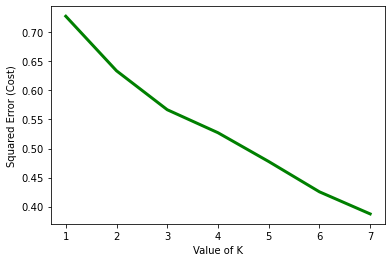

In [59]:
cost =[] 
BH_grouped_clustering = BH_grouped.drop('Neighborhood', 1)

for i in range(1, 8): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(BH_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      

# plot the cost against K values   
plt.plot(range(1, 8), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

In [60]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 0, 0, 1, 1, 1, 1, 1])

In [62]:
del neighborhoods_venues_sorted['Cluster Labels']
neighborhoods_venues_sorted

Bairro 1st Most Common Venue          2nd Most Common Venue  \
0         Alto Caicaras  Gym / Fitness Center                         Bakery   
1              Anchieta            Restaurant                       Pharmacy   
2        Atila de Paiva           Pizza Place           Fast Food Restaurant   
3            Boa Viagem  Brazilian Restaurant                            Bar   
4        Carlos Prates   Brazilian Restaurant  Paper / Office Supplies Store   
5                 Carmo  Brazilian Restaurant                 Ice Cream Shop   
6           Cidade Nova  Gym / Fitness Center                 Ice Cream Shop   
7      Colegio Batista         Sandwich Place           Brazilian Restaurant   
8       Conego Pinheiro           Pizza Place                            Bar   
9   Coracao Eucaristico                   Bar           Gym / Fitness Center   
10             Cruzeiro  Brazilian Restaurant                       Pharmacy   
11              Estoril                   Bar           Gym / Fitness Center   
12            Floresta                    Bar                         Bakery   
13      Jardim America                 Bakery              Food & Drink Shop   
14              Juliana        Clothing Store           Fast Food Restaurant   
15            Lagoinha                 Bakery           Brazilian Restaurant   
16              Lourdes  Brazilian Restaurant                            Bar   
17          Mala e Cuia   Japanese Restaurant           Brazilian Restaurant   
18      Maria Virginia                 Bakery                   Burger Joint   
19         Pindura Saia  Brazilian Restaurant                            Bar   
20         Santa Isabel  Brazilian Restaurant                     Restaurant   
21         Santa Tereza  Brazilian Restaurant                 Ice Cream Shop   
22          Sao Vicente        Ice Cream Shop                            Bar   
23            Vila Dias                   Bar                 Ice Cream Shop   
24           Vila FUMEC  Brazilian Restaurant                       Pharmacy   
25          Vila Sumare        Clothing Store                    Pizza Place   
26             Virginia           Pizza Place           Fast Food Restaurant   

   3rd Most Common Venue          4th Most Common Venue 5th Most Common Venue  \
0              Pet Store                            Bar            Restaurant   
1            Pizza Place           Gym / Fitness Center    Seafood Restaurant   
2           Soccer Field                      BBQ Joint         Big Box Store   
3                   Café                          Plaza  Gym / Fitness Center   
4               Pharmacy                     Restaurant           Pizza Place   
5            Pizza Place                            Pub            Restaurant   
6   Brazilian Restaurant                            Bar                Bakery   
7       Department Store                         Bakery       Cultural Center   
8                 Bakery           Gym / Fitness Center         Grocery Store   
9   Brazilian Restaurant                 Sandwich Place        Ice Cream Shop   
10            Restaurant                            Bar                Bakery   
11              Pharmacy           Fast Food Restaurant                  Café   
12               Theater                     Restaurant  Brazilian Restaurant   
13           Beer Garden               Department Store      Business Service   
14     Electronics Store                     Restaurant        Chocolate Shop   
15                   Gym                            Bar            Restaurant   
16                  Café                     Restaurant  Gym / Fitness Center   
17            Restaurant           Gym / Fitness Center           Pizza Place   
18    Mineiro Restaurant                          Hotel                 Plaza   
19              Pharmacy                         Bakery           IT Services   
20                   Bar  Paper / Office Supplies Store  Gym / Fitness Cent

In [63]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

BH_merged = final_df
neighborhoods_venues_sorted.rename(columns = {'Neighborhood':'Bairro'}, inplace = True)

BH_merged = BH_merged.join(neighborhoods_venues_sorted.set_index('Bairro'), on='Bairro')
print(BH_merged.shape)
BH_merged = BH_merged.dropna()
BH_merged = BH_merged.drop_duplicates(subset='Bairro', keep='first')
BH_merged.head()

(496, 16)


Bairro         Zona    Regional       Long        Lat  \
15         Lourdes  HIPERCENTRO  Centro-Sul -43.938273 -19.929719   
32    Santa Tereza   ZONA LESTE       Leste -43.923958 -19.919069   
34     Cidade Nova   ZONA LESTE    Nordeste -43.925568 -19.893079   
35  Carlos Prates    ZONA OESTE    Noroeste -43.958106 -19.918387   
54        Anchieta     ZONA SUL  Centro-Sul -43.928552 -19.952273   

    Cluster Labels 1st Most Common Venue          2nd Most Common Venue  \
15             0.0  Brazilian Restaurant                            Bar   
32             1.0  Brazilian Restaurant                 Ice Cream Shop   
34             1.0  Gym / Fitness Center                 Ice Cream Shop   
35             0.0  Brazilian Restaurant  Paper / Office Supplies Store   
54             2.0            Restaurant                       Pharmacy   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
15                  Café            Restaurant  Gym / Fitness Center   
32                   Bar             Nightclub           Snack Place   
34  Brazilian Restaurant                   Bar                Bakery   
35              Pharmacy            Restaurant           Pizza Place   
54           Pizza Place  Gym / Fitness Center    Seafood Restaurant   

   6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
15           Snack Place                   Hotel           Coffee Shop   
32        Clothing Store  Furniture / Home Store                   Spa   
34           Supermarket                   Plaza              Pharmacy   
35                   Bar             Snack Place             Nightclub   
54         Deli / Bodega             Coffee Shop           Supermarket   

   9th Most Common Venue 10th Most Common Venue  
15          Dessert Shop                  Plaza  
32           Pizza Place             Restaurant  
34         Shopping Mall         Shop & Service  
35          Dance Studio                  Plaza  
54          Gourmet Shop                  Plaza

#### Mapping all the clustered neighborhoods

In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BH_merged['Lat'], BH_merged['Long'], BH_merged['Bairro'], BH_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters       

In [46]:
BH_grouped = BH_grouped.drop_duplicates(subset='Neighborhood', keep='first')
BH_merged = BH_merged.drop_duplicates(subset='Bairro', keep='first')

#### Listing First Cluster neighborhoods

In [65]:
BH_merged.loc[BH_merged['Cluster Labels'] == 0, BH_merged.columns[[0,2] + list(range(5, BH_merged.shape[1]))]]

Bairro    Regional  Cluster Labels 1st Most Common Venue  \
15          Lourdes  Centro-Sul             0.0  Brazilian Restaurant   
35   Carlos Prates     Noroeste             0.0  Brazilian Restaurant   
106        Cruzeiro  Centro-Sul             0.0  Brazilian Restaurant   
185      Boa Viagem  Centro-Sul             0.0  Brazilian Restaurant   
468    Pindura Saia  Centro-Sul             0.0  Brazilian Restaurant   
471    Santa Isabel  Centro-Sul             0.0  Brazilian Restaurant   
481      Vila FUMEC  Centro-Sul             0.0  Brazilian Restaurant   
483     Mala e Cuia  Centro-Sul             0.0   Japanese Restaurant   

             2nd Most Common Venue 3rd Most Common Venue  \
15                             Bar                  Café   
35   Paper / Office Supplies Store              Pharmacy   
106                       Pharmacy            Restaurant   
185                            Bar                  Café   
468                            Bar              Pharmacy   
471                     Restaurant                   Bar   
481                       Pharmacy                   Bar   
483           Brazilian Restaurant            Restaurant   

             4th Most Common Venue 5th Most Common Venue  \
15                      Restaurant  Gym / Fitness Center   
35                      Restaurant           Pizza Place   
106                            Bar                Bakery   
185                          Plaza  Gym / Fitness Center   
468                         Bakery           IT Services   
471  Paper / Office Supplies Store  Gym / Fitness Center   
481                     Restaurant                Bakery   
483           Gym / Fitness Center           Pizza Place   

    6th Most Common Venue    7th Most Common Venue  \
15            Snack Place                    Hotel   
35                    Bar              Snack Place   
106             BBQ Joint              Pizza Place   
185           Snack Place            Historic Site   
468     French Restaurant       Italian Restaurant   
471           Supermarket  Fruit & Vegetable Store   
481           IT Services       Italian Restaurant   
483                   Bar                 Pharmacy   

             8th Most Common Venue    9th Most Common Venue  \
15                     Coffee Shop             Dessert Shop   
35                       Nightclub             Dance Studio   
106  Vegetarian / Vegan Restaurant                Juice Bar   
185                   Dessert Shop               Restaurant   
468                     Steakhouse               Restaurant   
471                     Food Truck                 Pharmacy   
481           Gym / Fitness Center               Food Truck   
483             Italian Restaurant  Fruit & Vegetable Store   

    10th Most Common Venue  
15                   Plaza  
35                   Plaza  
106          Shopping Mall  
185                  Hotel  
468              BBQ Joint  
471              BBQ Joint  
481              BBQ Joint  
483            Coffee Shop

#### Listing Second Cluster neighborhoods

In [66]:
BH_merged.loc[BH_merged['Cluster Labels'] == 1, BH_merged.columns[[0,2] + list(range(5, BH_merged.shape[1]))]]

Bairro           Regional  Cluster Labels  \
32          Santa Tereza              Leste             1.0   
34           Cidade Nova           Nordeste             1.0   
59             Floresta   Centro-Sul/ Leste             1.0   
64       Jardim America               Oeste             1.0   
71      Colegio Batista     Leste/ Nordeste             1.0   
116  Coracao Eucaristico           Noroeste             1.0   
123        Alto Caicaras           Noroeste             1.0   
186              Estoril              Oeste             1.0   
212            Lagoinha     Nord./ Noroeste             1.0   
215      Maria Virginia            Nordeste             1.0   
217                Carmo         Centro-Sul             1.0   
357            Vila Dias              Leste             1.0   
405          Sao Vicente              Leste             1.0   
412      Conego Pinheiro              Leste             1.0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
32   Brazilian Restaurant        Ice Cream Shop                   Bar   
34   Gym / Fitness Center        Ice Cream Shop  Brazilian Restaurant   
59                    Bar                Bakery               Theater   
64                 Bakery     Food & Drink Shop           Beer Garden   
71         Sandwich Place  Brazilian Restaurant      Department Store   
116                   Bar  Gym / Fitness Center  Brazilian Restaurant   
123  Gym / Fitness Center                Bakery             Pet Store   
186                   Bar  Gym / Fitness Center              Pharmacy   
212                Bakery  Brazilian Restaurant                   Gym   
215                Bakery          Burger Joint    Mineiro Restaurant   
217  Brazilian Restaurant        Ice Cream Shop           Pizza Place   
357                   Bar        Ice Cream Shop  Brazilian Restaurant   
405        Ice Cream Shop                   Bar  Brazilian Restaurant   
412           Pizza Place                   Bar                Bakery   

    4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
32              Nightclub           Snack Place             Clothing Store   
34                    Bar                Bakery                Supermarket   
59             Restaurant  Brazilian Restaurant                IT Services   
64       Department Store      Business Service                   Bus Stop   
71                 Bakery       Cultural Center                Supermarket   
116        Sandwich Place        Ice Cream Shop                       Café   
123                   Bar            Restaurant               Burger Joint   
186  Fast Food Restaurant                  Café                Pizza Place   
212                   Bar            Restaurant         Seafood Restaurant   
215                 Hotel                 Plaza  Middle Eastern Restaurant   
217                   Pub            Restaurant                        Bar   
357           Snack Place           Pizza Place                  Nightclub   
405             Nightclub                Bakery             Clothing Store   
412  Gym / Fitness Center         Grocery Store          Electronics Store   

         7th Most Common Venue 8th Most Common Venue   9th Most Common Venue  \
32      Furniture / Home Store                   Spa             Pizza Place   
34                       Plaza              Pharmacy           Shopping Mall   
59                Empada House        Sandwich Place      Salon / Barbershop   
64                  Restaurant   Martial Arts School  Furniture / Home Store   
71          Mineiro Restaurant           Event Space             Snack Place   
116                Snack Place             BBQ Joint                  Bakery   
123       Brazilian Restaurant   Japanese Restaurant             Pizza Place   
186             Cosmetics Shop            Restaurant               BBQ Joint   
212             Sandwich Place  Fast Food Restaurant            Burger Joint   
215  

#### Listing Third Cluster neighborhoods

In [67]:
BH_merged.loc[BH_merged['Cluster Labels'] == 2, BH_merged.columns[[0,2] + list(range(5, BH_merged.shape[1]))]]

Bairro    Regional  Cluster Labels 1st Most Common Venue  \
54         Anchieta  Centro-Sul             2.0            Restaurant   
156         Juliana       Norte             2.0        Clothing Store   
251     Vila Sumare    Noroeste             2.0        Clothing Store   
346  Atila de Paiva    Barreiro             2.0           Pizza Place   
371        Virginia       Oeste             2.0           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
54               Pharmacy           Pizza Place  Gym / Fitness Center   
156  Fast Food Restaurant     Electronics Store            Restaurant   
251           Pizza Place   Sporting Goods Shop    Italian Restaurant   
346  Fast Food Restaurant          Soccer Field             BBQ Joint   
371  Fast Food Restaurant        Clothing Store  Brazilian Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
54     Seafood Restaurant         Deli / Bodega           Coffee Shop   
156        Chocolate Shop           Coffee Shop     Mobile Phone Shop   
251           Coffee Shop     Electronics Store    Seafood Restaurant   
346         Big Box Store                   Bar                Bakery   
371            Food Truck                  Café      Department Store   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
54            Supermarket          Gourmet Shop                  Plaza  
156  Brazilian Restaurant           Men's Store             Food Court  
251            Steakhouse  Fast Food Restaurant             Restaurant  
346      Sushi Restaurant  Brazilian Restaurant                Brewery  
371     Mobile Phone Shop            Food Court     Light Rail Station

#### Listing Fourth Cluster neighborhoods

In [68]:
BH_merged.loc[BH_merged['Cluster Labels'] == 3, BH_merged.columns[[0,2] + list(range(5, BH_merged.shape[1]))]]

Empty DataFrame
Columns: [Bairro, Regional, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []

In [69]:
df_vrest = BH_venues[BH_venues['Venue Category'] == 'Vegetarian / Vegan Restaurant'].reset_index(drop=True)
print(df_vrest.shape)
df_vrest.head(17)

(23, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Sagrada Familia             -19.910513              -43.925402   
1                  Lourdes             -19.929719              -43.938273   
2           Carlos Prates              -19.918387              -43.958106   
3           Carlos Prates              -19.918387              -43.958106   
4              Nova Suissa             -19.930074              -43.982263   
5                 Anchieta             -19.952273              -43.928552   
6             Funcionarios             -19.937933              -43.925816   
7                 Cruzeiro             -19.948131              -43.922110   
8                 Cruzeiro             -19.948131              -43.922110   
9             Maria Helena             -19.802357              -43.999890   
10                Calafate             -19.928312              -43.981820   
11             Barro Preto             -19.928242              -43.956235   
12              Boa Viagem             -19.930652              -43.936612   
13                   Carmo             -19.945243              -43.933159   
14                Imbaubas             -19.944025              -43.991036   
15  Vila Nova Gameleira II             -19.940323              -43.991680   
16          Vila Boa Vista             -19.895614              -43.893685   

                            Venue  Venue Latitude  Venue Longitude  \
0                     Bio Natural      -19.912956       -43.929274   
1                  Fonte de Minas      -19.925897       -43.939719   
2       Salute Self Service Light      -19.922022       -43.956090   
3       Salute Self Service Light      -19.922022       -43.956090   
4       Restaurante Mesa do Sábio      -19.927994       -43.979669   
5                     Mundo Verde      -19.951166       -43.927985   
6         Formoso Cozinha Natural      -19.942189       -43.926158   
7                 Néctar da Serra      -19.949217       -43.920708   
8                     Sumô Lounge      -19.949395       -43.920803   
9               Vegetariano Green      -19.799255       -43.999966   
10      Restaurante Mesa do Sábio      -19.927994       -43.979669   
11                  Natural Light      -19.927404       -43.951875   
12                       O Vegano      -19.934432       -43.934831   
13           Restaurante Nascente      -19.948444       -43.933725   
14        Vegetariano no Esquinão      -19.943655       -43.993044   
15        Vegetariano no Esquinão      -19.943655       -43.993044   
16  Morcatto Hortifrutigranjeiros      -19.897563       -43.897664   

                   Venue Category  
0   Vegetarian / Vegan Restaurant  
1   Vegetarian / Vegan Restaurant  
2   Vegetarian / Vegan Restaurant  
3   Vegetarian / Vegan Restaurant  
4   Vegetarian / Vegan Restaurant  
5   Vegetarian / Vegan Restaurant  
6   Vegetarian / Vegan Restaurant  
7   Vegetarian / Vegan Restaurant  
8   Vegetarian / Vegan Restaurant  
9   Vegetarian / Vegan Restaurant  
10  Vegetarian / Vegan Restaurant  
11  Vegetarian / Vegan Restaurant  
12  Vegetarian / Vegan Restaurant  
13  Vegetarian / Vegan Restaurant  
14  Vegetarian / Vegan Restaurant  
15  Vegetarian / Vegan Restaurant  
16  Vegetarian / Vegan Restaurant

#### Selecting one neighborhood for cluster that has not any Vegan/Vegetarian Restaurant although has lots of hot spots

In [71]:
list_3_Neigs = ['Carlos Prates ', 'Carmo', 'Virginia'] 

num_top_venues = 5

for hood in list_3_Neigs:
    print("---- "+hood+" ----")
    temp = BH_grouped[BH_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue_category','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Carlos Prates  ----
                  venue_category  freq
0  Paper / Office Supplies Store  0.09
1                     Restaurant  0.09
2           Brazilian Restaurant  0.09
3                       Pharmacy  0.09
4                    Pizza Place  0.06


---- Carmo ----
         venue_category  freq
0  Brazilian Restaurant  0.07
1        Ice Cream Shop  0.05
2                   Bar  0.05
3            Restaurant  0.05
4                   Pub  0.05


---- Virginia ----
         venue_category  freq
0           Pizza Place  0.09
1  Fast Food Restaurant  0.09
2        Clothing Store  0.07
3  Brazilian Restaurant  0.06
4     Mobile Phone Shop  0.04




### Visual check in that map if the selected neighborhood are really good places to open a Vegan/Vegeratian Restaurant

In [72]:
df_check = df_40_80[(df_40_80['Neighborhood'] == 'Carlos Prates ') | (df_40_80['Neighborhood'] == 'Carmo') | (df_40_80['Neighborhood'] == 'Virginia') ]

df_check.shape

(182, 7)

In [73]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map

# add populer spots as blue circle markers   
for lat, lng, label in zip(df_check['Venue Latitude'], df_check['Venue Longitude'], df_check['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        fill=True,
        color='blue',
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(venues_map) 
    
# add the Vegan / Vegetarian Restaurants as red circle markers
for lat, lng, label in zip(df_vrest['Venue Latitude'], df_vrest['Venue Longitude'], df_vrest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.4,
        parse_html=False).add_to(venues_map)
    

# display map
venues_map

## CONCLUSION

As we can see, although there is no Vegan/Vegetarian Restaurant in Carmo and Carlos Prates, there are some nearby them.

With this in mind, we can say that open this restaurant in Virginia would be the best alternative.